# 2º Trabalho Prático: Planejamento de Caminhos

## Introdução

Este trabalho tem como propósito explorar e implementar algoritmos de planejamento de caminhos e navegação em ambientes simulados, utilizando a plataforma CoppeliaSim. A realização deste projeto permitirá uma compreensão mais aprofundada dos conceitos teóricos associados ao planejamento de trajetórias em robótica móvel, bem como a aplicação prática desses conceitos em um ambiente simulado.

O problema abordado consiste na navegação de robôs em um ambiente virtual, onde os robôs devem encontrar trajetórias seguras e eficientes para alcançar seus objetivos, evitando obstáculos e seguindo caminhos viáveis. Para solucionar esse problema, serão implementados algoritmos de planejamento de caminhos, cada um com sua abordagem específica.

Um dos algoritmos a ser implementado é o Roadmap, que se baseia em uma representação gráfica do ambiente para encontrar trajetórias ótimas para os robôs. Ele utiliza pontos de referência no ambiente para criar uma estrutura de dados que representa as possíveis trajetórias, permitindo uma busca eficiente por caminhos viáveis.

Outro algoritmo a ser explorado é o Campos Potenciais, que emprega um modelo de forças para guiar os robôs em direção ao objetivo desejado, enquanto evita obstáculos no ambiente. Nesse método, as forças geradas pelos obstáculos influenciam a trajetória do robô, levando-o a seguir caminhos livres de colisões.

#### Importação de Bibliotecas

In [1]:
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
import math
import time
import numpy as np
import heapq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### Classes e Funções Compartilhadas

Este módulo foi desenvolvido para controlar robôs no ambiente de simulação CoppeliaSim. A organização dos objetos em classes e subclasses foi escolhida para melhorar a estrutura do código e facilitar a encapsulação, proporcionando uma gestão mais eficiente das funcionalidades relacionadas aos robôs.

A classe CoppeliaRobot desempenha um papel fundamental como a principal interface de controle para os robôs. Ela engloba métodos para movimento ao longo de trajetórias predefinidas e cálculos cinemáticos necessários para o deslocamento do robô. Inicialmente, o trabalho foi concebido para utilizar o modelo cinemático inverso, porém, devido à performance insatisfatória, optou-se por aplicar a inversão da matriz do modelo cinemático direto, conforme discutido em aula.

Uma decisão de design relevante é manter o movimento do robô predominantemente em direção à frente, reservando curvas apenas para interseções de trajetos. Essa abordagem foi inicialmente pensada para o robô youBot, permitindo sua passagem por espaços estreitos com maior fluidez nos movimentos. Além disso, uma margem de erro maior foi estabelecida para o posicionamento do robô, especialmente em ambientes texturizados como cavernas, onde alcançar certas posições se tornava desafiador.

In [2]:
client = RemoteAPIClient()
sim = client.require('sim')

class CoppeliaObject:
    
    def __init__ (self, name):
        self.name = name
        self.handle = sim.getObject (name)
        self.update_location ()
        
    def new_location (self, position, orientation):
        sim.setObjectPosition (self.handle, position)
        sim.setObjectOrientation (self.handle, orientation)
        self.update_location ()
        
    def update_location (self):
        self.global_position = sim.getObjectPosition (self.handle)
        self.global_orientation = sim.getObjectOrientation (self.handle)

class CoppeliaRobot (CoppeliaObject):
    
    def __init__ (self, name, length, wheels, laser = None):
        # wheel_joints recebe um vetor de objetos do tipo Coppelia_Wheel
        self.length = length
        self.wheels = wheels
        self.laser = laser
        CoppeliaObject.__init__ (self, name)

    def calc_linear_velocity (self, position, orientation):
        delta_pos = np.array (position) - np.array (self.global_position[:2])
        delta_ori = orientation - self.global_orientation[2]
        q_dot = np.array ((delta_pos[0], delta_pos[1], delta_ori))
        return q_dot

    def inverse_kinematics_omnidirectional (self, velocity, orientation):
        L = self.length
        direct_matrix = self.wheels[0].radius / 3 * np.array([[-np.sqrt(3),          0, np.sqrt(3)],
                                                              [          1,         -2,          1],
                                                              [      1 / L,      1 / L,      1 / L]])
        inverse_matrix = np.linalg.inv (rotation_z (orientation) @ direct_matrix)
        angular_velocity = inverse_matrix @ velocity
        return angular_velocity

    def follow_path (self, path):
        for stop in path:
            t = 0
            last_time = time.time()
            while np.linalg.norm (self.global_position[:2] - stop) > 0.1 and t < 5:
                angle = np.arctan2 (stop[1], stop[0])
                linear_velocity = self.calc_linear_velocity (stop, angle)
                wheels_velocity = self.inverse_kinematics_omnidirectional (linear_velocity, angle)
                for i in range (3):
                    self.wheels[i].set_velocity (wheels_velocity[i])
                self.update_location ()
                t = t + time.time() - last_time
                last_time = time.time()

class CoppeliaWheel (CoppeliaObject):
    
    def __init__ (self, name, radius):
        self.radius = radius
        CoppeliaObject.__init__ (self, name)

    def set_velocity (self, velocity):
        sim.setJointTargetVelocity (self.handle, velocity)

class CoppeliaLaser (CoppeliaObject):
    
    def __init__ (self, name, laser_range_data, laser_angle_data):
        self.laser_range_data = laser_range_data
        self.laser_angle_data = laser_angle_data

In [3]:
# Normalize angle to the range [-pi,pi)
def normalize_angle (angle):
    
    return np.mod (angle + np.pi, 2 * np.pi) - np.pi

In [4]:
def rotation_z (theta):
    
    return np.array ([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta),  np.cos(theta), 0],
                      [            0,              0, 1]])

## Planejamento de Caminhos com o Algoritmo de Campos Potênciais

#### Função de leitura de Laser

Esta é uma das principais funções para o funcionamento deste método. Funciona recebendo como parâmetros as informações necessárias do Laser, como seu nome e o que ele deve pegar e retorna um vetor com as informações de distância e ângulos captadas pelo Laser. No caso, a sua
limitação se dá pelo fato de que o Laser não captura informações que estejam a mais de 5 metros de distância, por isso a anulação de valores
com o valor 5 na função de repulsão. 

In [5]:
def read_sensor_data (range_data_signal_id="hokuyo_range_data", angle_data_signal_id="hokuyo_angle_data"):
    
    while sim.getStringSignal (range_data_signal_id) == None:
       continue
        
    string_range_data = sim.getStringSignal (range_data_signal_id)
    string_angle_data = sim.getStringSignal (angle_data_signal_id)

    raw_range_data = sim.unpackFloatTable (string_range_data)
    raw_angle_data = sim.unpackFloatTable (string_angle_data)

    return np.array ([raw_angle_data, raw_range_data]).T

#### Funções Campos Potenciais

Neste trecho, foi-se definido as funções de atração e repulsão para locomoção do robô. Com efeito, elas se baseiam nas leituras de posição atual do robô, do goal e do obstáculo (obtida com o Laser). No caso, a força de atração é baseada na diferença entre a posição do 
goal e do robô, multiplicada por um ganho constante. Note que esta função é retorna um vetor. 

Por fim, a foça de repulsão atua com a posição atual do robô, posição do obstáculo, um fator R para distância máxima permitida e um ganho constante. Neste caso,ela é necessária para que se evite a colisão do robô e este consiga efetuar sua trajetória sem ficar preso. No caso, note que esta também retorna um vetor e é inversalmente proporcional com a distância entre o robô e o obstáculo, i.e., quanto mais próxima do obstáculo, maior deve ser.

In [6]:
# Usar nomes de funções e atributos mais descritivos
def att_force (q, goal, katt = 0.01):
    return katt * (goal - q)

def rep_force(robotPosition, obs, R, krep=.1):
    
    # Obstáculo: (x, y, r)
    v = robotPosition[0:2] - obs[0:2]
    d1 = np.linalg.norm(v)
    
    rep = krep * (1/d1**2) * ((1/d1) - (1/R)) * (v/d1)    
    
    return rep


#### Funções para o funcionamento do método.
Primeiramente, definiu-se o caminho do robô, dos componentes e do Laser, para que se obtenha o Handle destes objetos. A partir daí, utilizando as funções de getObjectPosition e getObjectOrientation, obtivemos as posições iniciais do robô. A partir daí, fez-se o Path do Goal que é um referenceFrame obtido do Coppeliae obteve sua posição e orientação. Note que este é fixo durante todo código. Após isso, define-se cotas superiores de velocidade que o robô pode alcançar e realiza-se um laço de interação while que continua rodando até que a posição final do robô esteja com erro de 0.05 em relação ao Goal. Dentro desta interação, busca-se atualizar constantemente a posição do robô e sua orientação, para que se possa mudar o valor da força de atração entre o robô e o Goal a medida que este se aproxima do objetivo.
    
Dentro deste while, chama-se continuamente a função de leitura do laser baseada na posição atual do robô que retorna o vetor com valores de distância e ângulos. Para que se tenha um melhor controle sobre estes valores, realiza-se um outro laço de iteração para filtrar os valores que são menores que uma tolerância de 5, são removidos (pois retornariam valores espúrios e perderíamos memória calculando valores não válidos devido a distância). Daí, realizamos o cálculo da força de repulsão baseada nesses valores filtrados.
    
Por fim, realizamos os cálculos somando todas as forças de repulsão e definindo x_force e y_force como sendo o primeiro e o segundo valor (respectivamente) do vetor da soma da força de atração e todas as de repulsão. Fizemos isso para aplicar o controlador de Lucas-Orio, e a partir dos valores calculados de velocidade linear e ângular, aplicamos as restrições de velocidades máximas e mínimas permitidas, para que se tenha um limite para estas. Após isso, definimos as velocidades da roda do robô diferencial e ele continua andando até que esteja a uma distância menor que 0.05 do Goal
    

In [7]:
client = RemoteAPIClient()
sim = client.require('sim')

sim.startSimulation() 

# Handle para os dados do LASER e do Robô
robotname = './Pioneer_p3dx'
robotname_R_Motor = './Pioneer_p3dx/Pioneer_p3dx_rightMotor'
robotname_L_Motor = './Pioneer_p3dx/Pioneer_p3dx_leftMotor'
laser_range_data = "hokuyo_range_data"
laser_angle_data = "hokuyo_angle_data"

robotHandle = sim.getObjectHandle(robotname)    

robotLeftMotorHandle  = sim.getObjectHandle(robotname_L_Motor)
robotRightMotorHandle = sim.getObjectHandle(robotname_R_Motor)

robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)

goalFrame = sim.getObjectHandle('./ReferenceFrame')

position_goal = sim.getObjectPosition(goalFrame, sim.handle_world)
orientation_goal = sim.getObjectOrientation(goalFrame, sim.handle_world) 

sim.setObjectPosition(goalFrame, [position_goal[0], position_goal[1], 0], sim.handle_world)
sim.setObjectOrientation(goalFrame, [orientation_goal[0], orientation_goal[1], orientation_goal[2]], sim.handle_world) 
        
while rho > .05:

    robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)
    robotOri = sim.getObjectOrientation(robotHandle, sim.handle_world)        
    robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])        


    laser_data = read_sensor_data(laser_range_data, laser_angle_data)
    distLaser = []

    força_AtracTot = att_force(robotConfig, position_goal, 0.1)

    for i in laser_data:
        f1 = 0
        f2 = 0
        d1 = i[0]  # Correção aqui
        ang1 = i[1]  # Correção aqui
        
        if d1 < 5:
            distLaser.append(d1)
        else:
            continue
    
    dist_repuls = min(distLaser)

    x = dist_repuls * np.cos(ang1)
    y = dist_repuls * np.sin(ang1)
    distLaser = np.array([x ,y, 0])

    força_RepulsTot = rep_force(robotPos, distLaser, 2, 1)
    #faleat = np.random.uniform(-0.01,0.01,size=2)
    dx1 = força_AtracTot[0:2] + força_RepulsTot[0:2] #+ faleat
    dx = dx1[0]
    dy = dx1[1]

    dx1, dy1 = position_goal[:2] + robotConfig[:2]

    rho = np.sqrt(dx1**2 + dy1**2)

    kr = 1
    kt = 2

    v = kr*(dx*np.cos(robotConfig[2]) + dy*np.sin(robotConfig[2]))
    w = kt*(np.arctan2(dy,dx) - robotConfig[2])
            
    # Limit v,w to +/- max
    
    if v > 0 and v > maxv:
        v = maxv
    elif v < 0 and v < -maxv:
        v = -maxv 
    if w > 0 and w > maxw:
        w = maxw
    elif w < 0 and w < -maxw:
        w = -maxw       

    vr = ((2.0*v) + (w*L))/(2.0*r)
    vl = ((2.0*v) - (w*L))/(2.0*r)
    
    sim.setJointTargetVelocity(robotRightMotorHandle, vr)
    sim.setJointTargetVelocity(robotLeftMotorHandle, vl)


sim.setJointTargetVelocity(robotRightMotorHandle, 0)
sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

time.sleep (5)

Força de Atração:  [-0.28085965 -0.26475342]
Força de Repulsão  [-0.26401474 -0.26814734]
Velocidade do robô  0.5409494274313653  velocidade angular do robot  -11.00311688511368 

Velocidade do robô 2:  0.5409494274313653  velocidade angular do robot 2:  -0.7853981633974483 

Força de Atração:  [-0.27982122 -0.26478141]
Força de Repulsão  [-0.26475165 -0.27092984]
Velocidade do robô  0.5457549247846841  velocidade angular do robot  1.5499726238305636 

Velocidade do robô 2:  0.5457549247846841  velocidade angular do robot 2:  0.7853981633974483 

Força de Atração:  [-0.27809812 -0.26477092]
Força de Repulsão  [-0.26609984 -0.2756602 ]
Velocidade do robô  0.5341792655360069  velocidade angular do robot  -10.96578114843604 

Velocidade do robô 2:  0.5341792655360069  velocidade angular do robot 2:  -0.7853981633974483 

Força de Atração:  [-0.27712636 -0.2648018 ]
Força de Repulsão  [-0.2667416  -0.27832728]
Velocidade do robô  0.5575975603204485  velocidade angular do robot  1.518217114

Exception: 316: in sim.unpackFloatTable: one of the function's argument type is not correct.

## Planejamento de Caminhos com o Algoritmo Roadmap

### Implementação

#### Funções Relativas a Leitura e Impressão de Imagens

In [5]:
def read_binary_image (image_address):
    
    image = mpimg.imread (image_address)
    for row in range (len (image)):
        for col in range (len (image[row])):
            image[row][col] = 1 if image[row][col] < 1 else 0
            
    return image

def print_world_grid (world_grid, img_id = ""):
    
    x_len = len (world_grid[0])
    y_len = len (world_grid)
    
    figure = plt.figure (figsize = (10, 10 * y_len / x_len), dpi = 100)
    ax = figure.add_subplot (111, aspect = 'equal')

    ax.grid (which = 'major', axis = 'both', linestyle = '-', color = 'k', linewidth = .5)
    ax.set_xticks (np.arange (0, x_len))
    ax.set_yticks (np.arange (0, y_len))
    
    ax.imshow (1 - world_grid, cmap = 'Blues', extent = (0, x_len, 0, y_len), alpha = 0.6)
    #plt.savefig(f"world_{img_id}.png")
    #plt.close()

#### Classes de Dados

A classe World foi concebida para representar o ambiente do mundo, oferecendo métodos para discretizar o espaço em células e verificar a acessibilidade de áreas. O método discretize_world possibilita a divisão do mundo em uma grade de células com base no tamanho especificado da célula, identificando se cada célula está livre ou ocupada.

A decisão de não utilizar um buffer ao discretizar o mundo simplifica o processo de implementação e cálculo das posições das células. No entanto, essa abordagem direta e eficiente inviabiliza o movimento na diagonal, pois não garante espaço para o robô passar diagonalmente caso as células adjacentes estejam ocupadas. Por este motivo, optou-se pela heurística de distância de Manhattan para calcular as estimativas de custo de movimento entre células no espaço do mundo. Essa heurística é adequada para problemas de busca em grade, como a busca de caminhos, e fornece uma estimativa razoável do custo para alcançar o objetivo, mesmo em ambientes complexos.

Ao calcular a prioridade dos nós com base no custo atual e na heurística de distância de Manhattan em uma função separada, a classe Node pode ser adaptada para funcionar como parte de um algoritmo de busca BFS, onde a prioridade é determinada apenas pelo custo atual. Essa estrutura permite uma integração flexível com algoritmos de busca, oferecendo uma solução versátil para problemas de planejamento de caminhos no ambiente discretizado.

In [6]:
class World:
    
    def __init__ (self, image_address, real_dimensions):
        self.image_address = image_address
        self.world_matrix = read_binary_image (self.image_address)
        self.real_dimensions = real_dimensions
        self.scale = self.world_matrix.shape[:2] / self.real_dimensions
        
    def is_cell_area_free (self, row, col, cell_size):
        area_size = cell_size * self.scale
        
        left = int (col * area_size[0])
        right = int ((col + 1) * area_size[0])
        top = int (row * area_size[1])
        bottom = int ((row + 1) * area_size[1])
        
        return 1 if np.sum (self.world_matrix[top:bottom, left:right]) == 0 else 0
        
    def discretize_world (self, cell_size = 1):
        num_rows, num_cols = (self.real_dimensions / cell_size).astype(int)
        grid = np.zeros ((num_rows, num_cols))
        
        for row in range (num_rows):
            for col in range (num_cols):
                grid[row][col] = self.is_cell_area_free (row, col, cell_size)
                
        print_world_grid(grid)
        return grid

In [7]:
class Node:

    def __init__ (self, grid_position, parent, current_cost):
        self.grid_position = grid_position
        self.parent = parent
        self.current_cost = current_cost
        self.priority_score = current_cost # Se a função calc_priority_score não é chamada, o algoritmo funciona como uma busca em largura (BFS)

    def __lt__ (self, other):
        return self.priority_score < other.priority_score

    def manhattan_distance (self, goal_pos):
        return abs (self.grid_position[0] - goal_pos[0]) + abs (self.grid_position[1] - goal_pos[1])
        
    def calc_priority_score (self, goal_pos):
        self.heuristic_cost = self.manhattan_distance (goal_pos)
        self.priority_score = self.current_cost + self.heuristic_cost

#### Funções Relativas a Busca de Caminhos com o Algoritmo A*

O algoritmo A* foi escolhido devido à sua eficácia na busca do caminho ótimo em um espaço de estados, visando encontrar soluções eficientes em termos de custo para problemas de planejamento de caminhos. Optamos por não inicializar todas as células do mapa como vértices, gerando apenas os vértices encontrados durante a execução do algoritmo A*. Essa abordagem reduz a complexidade espacial, evitando a criação de uma estrutura de dados desnecessariamente grande e economizando memória durante a execução do algoritmo.

Para marcar as células exploradas e o caminho encontrado, decidimos utilizar os valores 2 e 3, respectivamente. Essa escolha proporciona uma melhor visualização do processo de busca e do caminho resultante no mapa binário, eliminando a necessidade de uma matriz auxiliar. Além disso, facilita a distinção entre células exploradas e parte do caminho na imagem gerada ao fim da execução.

Foi tomada a decisão de utilizar o módulo heapq para gerenciar a lista de fronteira durante a busca A*. Essa escolha se deve à eficiência e simplicidade proporcionadas pela estrutura de heap binária. O uso de heapq simplifica a implementação do algoritmo, ao mesmo tempo em que melhora sua eficiência durante a execução.

In [8]:
def is_cell_invalid (cell, world):
    
    if cell [0] < 0: return True
    if cell [1] < 0: return True
    if cell [0] >= len (world[0]): return True
    if cell [1] >= len (world): return True
        
    return False

def reconstruct_path_to (last_node, world):

    path = [last_node.grid_position]
    world[last_node.grid_position[1]][last_node.grid_position[0]] = 3
    
    while last_node.parent is not None:
        path.append(last_node.parent.grid_position)
        last_node = last_node.parent
        world[last_node.grid_position[1]][last_node.grid_position[0]] = 3

    return path, world

def A_star (start, end, binary_world):

    frontier = []
    path = []
    binary_world[start[1]][start[0]] = 1
    heapq.heappush (frontier, Node (start, None, 0))

    while len(frontier) > 0:
        current_node = heapq.heappop(frontier)

        if not (current_node.grid_position - end).any():
            path, binary_world = reconstruct_path_to (current_node, binary_world)
            break

        for shift_one in [[0, 1], [0, -1], [1, 0], [-1, 0]]:
            neighbor_position = (current_node.grid_position + shift_one).astype(int)
            
            if is_cell_invalid (neighbor_position, binary_world): continue
            if binary_world[neighbor_position[1]][neighbor_position[0]] == 0: continue # 0 -> OBSTACULO
            if binary_world[neighbor_position[1]][neighbor_position[0]] == 2: continue # 2 -> EXPLORADO
            else: binary_world[neighbor_position[1]][neighbor_position[0]] = 2

            neighbor = Node (neighbor_position, current_node, current_node.current_cost + 1)
            neighbor.calc_priority_score (end)
            heapq.heappush (frontier, neighbor)

    
    print_world_grid (binary_world)
        
    return path

![SegmentLocal](imagens/gif_a_star.gif "segment")

#### Funções Auxiliares de Transformação, Controle e Integração

Este módulo oferece funções para transformar coordenadas entre o sistema global e a grade do mapa, além de fornecer uma função auxiliar para encontrar o caminho até um objetivo.

- calc_grid_position: Move o ponto de origem do centro do mundo para o canto superior esquerdo da grade e calcula a posição da célula correspondente para uma dada posição global. Isso simplifica o acesso direto à matriz do mundo, eliminando a necessidade de cálculos adicionais para verificar a ocupação da célula ou se ela foi explorada.
  
- calc_map_position: Realiza o inverso de calc_grid_position, convertendo a posição de uma célula na grade para o sistema de coordenadas global. Esta função é útil para mapear o caminho calculado de volta para o mundo global.
  
- find_goal: Facilita a busca do caminho até um objetivo para um robô em um ambiente de mapa discreto. Calcula as posições das células do robô e do objetivo, executa o algoritmo A* para encontrar o caminho na grade do mapa e, em seguida, converte as coordenadas de volta para o mundo global. Essa função simplifica a testagem do código e diminui o tamanho dos testes, facilitando sua reprodução.al para facilitar a testagem do código e diminuir o tamanho e facilitar a reprodução dos testes

In [9]:
# Move o ponto de origem do centro do mundo para o canto superior esquerdo da grade e encontra a celula correspondente
def calc_grid_position (global_pos, cell_size, grid_size):

    x_pos = np.floor (global_pos[0] / cell_size + grid_size[0] / 2)
    y_pos = np.floor (-global_pos[1] / cell_size + grid_size[1] / 2)

    return np.array ((x_pos, y_pos)).astype(int)

def calc_map_position (grid_pos, cell_size, grid_size):

    x_pos = (grid_pos[0] + 0.5 - grid_size[0] / 2) * cell_size
    y_pos = -(grid_pos[1] + 0.5 - grid_size[1] / 2) * cell_size

    return np.array ((x_pos, y_pos))

def find_goal (robot, goal, world_map, cell_size):

    robot_cell = calc_grid_position (robot.global_position, cell_size, [len (world_map[0]), len (world_map)])
    goal_cell = calc_grid_position (goal.global_position, cell_size, [len (world_map[0]), len (world_map)])
    
    grid_path = A_star (robot_cell, goal_cell, world_map)

    world_path = [calc_map_position (stop, cell_size, [len (world_map[0]), len (world_map)]) for stop in grid_path]
    
    robot.follow_path (np.flip (world_path, 0))

### Testes e Análise de Resultados

Para garantir a estabilidade desde o início da simulação, decidimos configurar a velocidade das rodas do robô para zero, evitando movimentos indesejados. Isso é fundamental para garantir a segurança durante os estágios iniciais da execução.

Ao discretizar o ambiente, é crucial selecionar o tamanho da célula considerando dois critérios principais: primeiro, deve ser um divisor comum das dimensões do mundo, garantindo uma correspondência adequada entre a imagem projetada e os eixos do gráfico; segundo, deve ser maior que o tamanho do robô, garantindo que cada célula possa conter completamente o robô, evitando colisões e garantindo uma representação precisa do ambiente.

Encontramos desafios ao gerar a imagem da caverna e ao determinar a inclinação real do terreno devido à falta de um mapa preciso das paredes e ao uso de uma textura para representar os obstáculos. Essa limitação pode impactar a precisão das operações de planejamento de trajetória e movimento do robô, tornando essas tarefas mais desafiadoras.

Além disso, decidimos criar mapas individuais para cada robô com o objetivo de evitar colisões e interferências entre eles. Essa abordagem permite que cada robô planeje suas trajetórias com base em sua própria percepção do ambiente, melhorando a segurança e eficiência das operações de navegação.

<b>Este teste é conduzido em um mapa de autoria própria, visando analisar o desempenho do algoritmo em um ambiente que foi mapeado e controlado.</b>

Tempo de Execução: 44.35428810119629


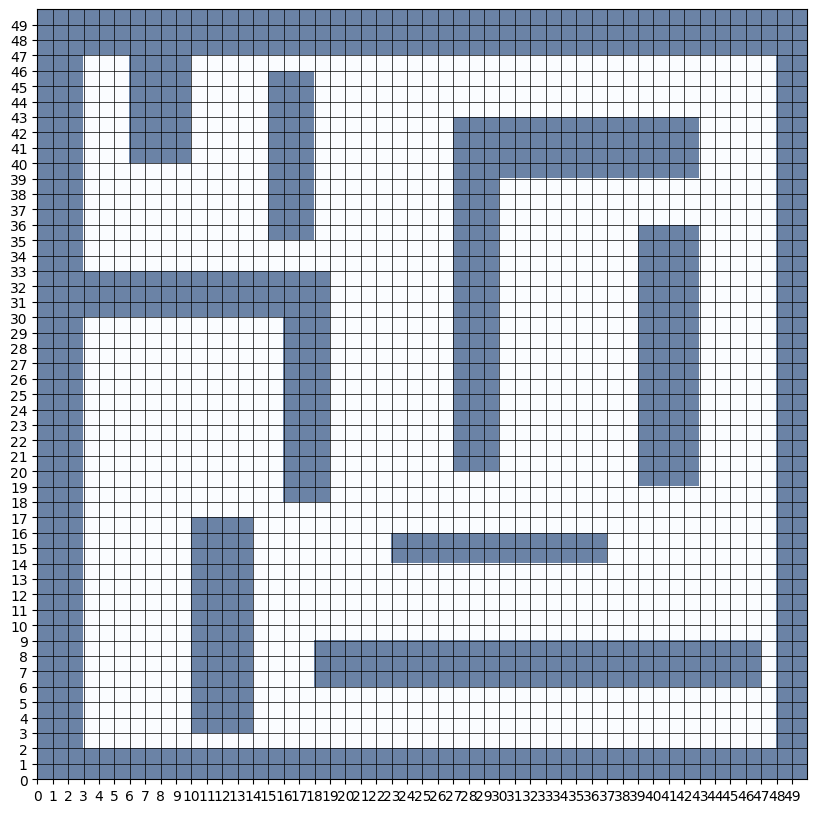

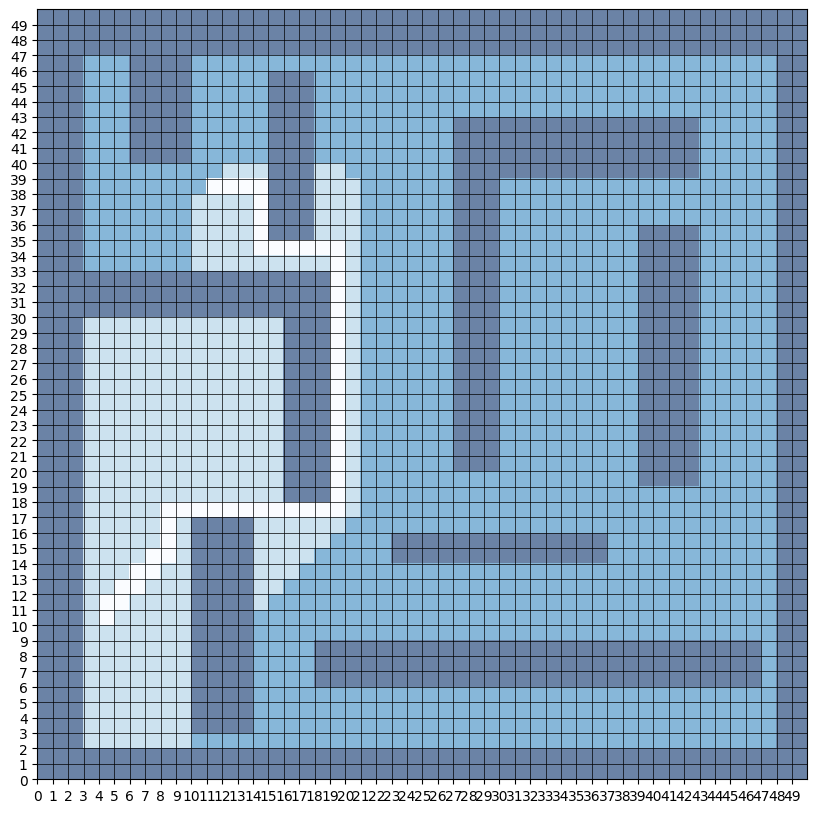

In [10]:
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/maze_robotino.ttt")
sim.startSimulation ()

robotino = CoppeliaRobot ("/robotino", 0.135, [])

robotino.wheels.append (CoppeliaWheel ("/wheel0_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel1_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel2_joint", 0.040))

for i in range (3):
    robotino.wheels[i].set_velocity (0)

goal = CoppeliaObject ("/Goal")

world = World ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/imagens/maze.png", np.array([20,20]))
world_map = world.discretize_world (0.4) # Tamanho da celula deve ser um divisor comum das dimensões do mundo e deve ser maior que o robô (0.27)

control = time.time()
find_goal (robotino, goal, world_map, 0.4)
print (f"Tempo de Execução: {time.time() - control}")

sim.stopSimulation ()
time.sleep (5)

Após a realização do teste, foi constatado que o robô se move com facilidade, alcançando o objetivo sem colidir com nenhum obstáculo ou desviar-se do caminho planejado. O tempo de execução do teste foi satisfatório, e o caminho planejado pode ser visualizado durante a execução.

<b>No teste a seguir, o mapa possui uma precisão reduzida e o ambiente da caverna apresenta terreno mais incerto, aumentando significativamente a dificuldade para que o robô localize e siga o caminho até o objetivo.</b>

Tempo de Execução: 68.79868006706238


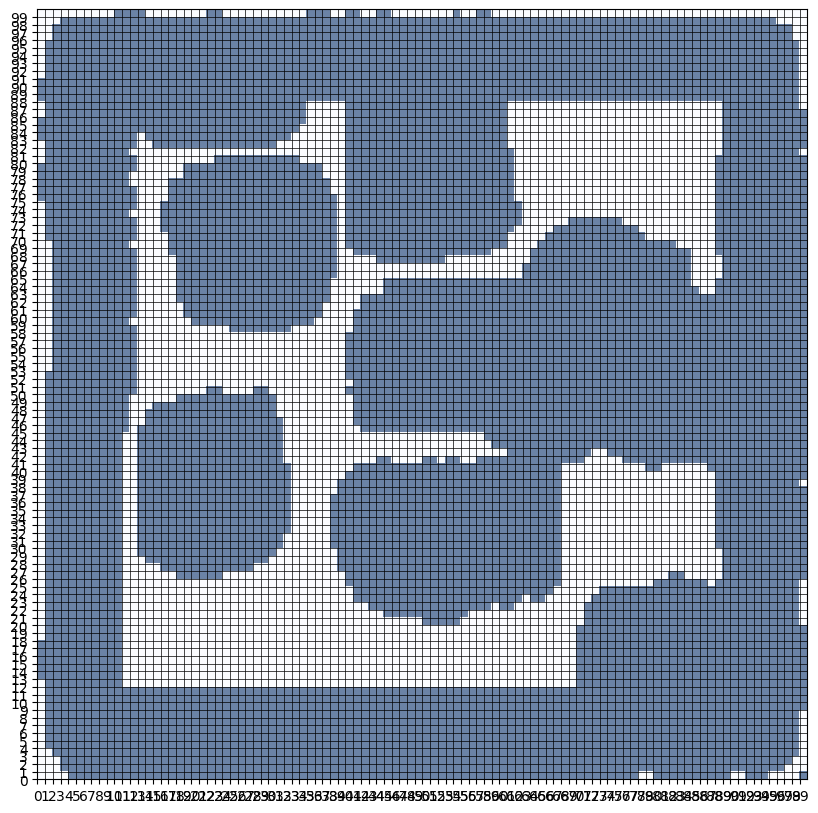

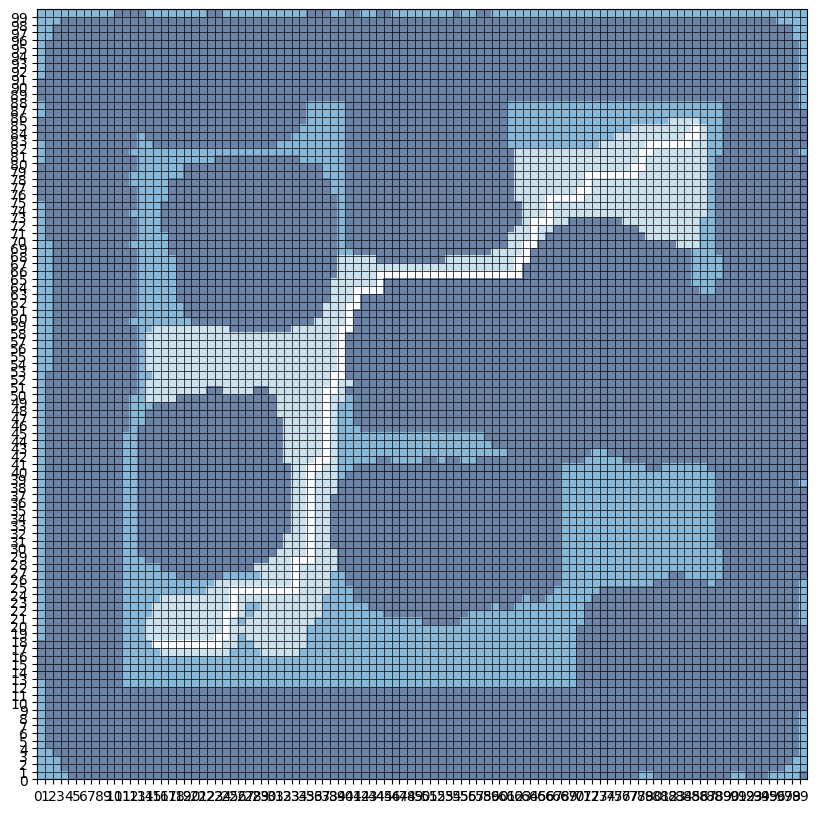

In [11]:
sim.loadScene ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/cave_robotino.ttt")
sim.startSimulation ()

robotino = CoppeliaRobot ("/robotino", 0.135, [])

robotino.wheels.append (CoppeliaWheel ("/wheel0_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel1_joint", 0.040))
robotino.wheels.append (CoppeliaWheel ("/wheel2_joint", 0.040))

for i in range (3):
    robotino.wheels[i].set_velocity (0)

goal = CoppeliaObject ("/Goal")

world = World ("C:/Users/tatia/Desktop/UFMG/RM/TP2/mapas/imagens/cave.png", np.array([40,40]))
world_map = world.discretize_world (0.4)

control = time.time()
find_goal (robotino, goal, world_map, 0.4)
print (f"Tempo de Execução: {time.time() - control}")

sim.stopSimulation ()
time.sleep (5)

Após a execução do teste, observou-se que o robô iniciou o trajeto com sucesso, porém encontrou dificuldades para desviar de alguns obstáculos, resultando em colisões. Essas dificuldades podem ser atribuídas às imprecisões no mapa gerado, que podem não refletir totalmente as condições do ambiente. No entanto, o robô conseguiu eventualmente contornar os obstáculos e alcançar o objetivo. O tempo de execução do teste foi registrado, juntamente com o caminho planejado, proporcionando insights sobre a eficácia do algoritmo em condições desafiadoras.

## Conclusão

Em resumo, este trabalho nos proporcionou uma experiência valiosa no campo da robótica, permitindo-nos explorar diferentes algoritmos e técnicas de planejamento e navegação. Os algoritmos de Roadmap e de Campos Potenciais demonstraram ser eficazes na busca de caminhos e na navegação em ambientes desafiadores. No entanto, enfrentamos dificuldades na implementação do algoritmo de Campos Potenciais. Esta experiência nos proporcionou insights importantes sobre os desafios práticos e teóricos do planejamento de trajetórias para robôs móveis, preparando-nos para futuros projetos e aprendizados nesta área.